This guide reviews methods to get a model to cite which parts of the source documents it referenced in generating its response.

We will cover five methods:

Using tool-calling to cite document IDs;
Using tool-calling to cite documents IDs and provide text snippets;
Direct prompting;
Retrieval post-processing (i.e., compressing the retrieved context to make it more relevant);
Generation post-processing (i.e., issuing a second LLM call to annotate a generated answer with citations).
We generally suggest using the first item of the list that works for your use-case. That is, if your model supports tool-calling, try methods 1 or 2; otherwise, or if those fail, advance down the list.

Let's first create a simple RAG chain. To start we'll just retrieve from Wikipedia using the WikipediaRetriever. We will use the same LangGraph implementation from the RAG Tutorial.


# Setup

First we'll need to install some dependencies:


In [4]:
%pip install -qU langchain-community wikipedia

Note: you may need to restart the kernel to use updated packages.


Let's first select a LLM:


In [5]:
%pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [6]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

We can now load a retriever and construct our prompt:


In [7]:
from langchain_community.retrievers import WikipediaRetriever
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "You're a helpful AI assistant. Given a user question "
    "and some Wikipedia article snippets, answer the user "
    "question. If none of the articles answer the question, "
    "just say you don't know."
    "\n\nHere are the Wikipedia articles: "
    "{context}"
)

retriever = WikipediaRetriever(top_k_results=6, doc_content_chars_max=2000)
prompt = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{question}")
])

prompt.pretty_print()

================================ System Message ================================

You're a helpful AI assistant. Given a user question and some Wikipedia article snippets, answer the user question. If none of the articles answer the question, just say you don't know.

Here are the Wikipedia articles: {context}

================================ Human Message =================================

{question}


Now that we've got a model, retriver and prompt, let's chain them all together. Following the how-to guide on adding citations to a RAG application, we'll make it so our chain returns both the answer and the retrieved Documents. This uses the same LangGraph implementation as in the RAG Tutorial.


In [8]:
%pip install langgraph -qU

Note: you may need to restart the kernel to use updated packages.


In [9]:
from langchain_core.documents import Document
from langgraph.graph import END, START, StateGraph
from typing_extensions import List, TypedDict


# Define state for the application
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


# Defone application steps
def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)

    return {"answer": response.content}


# Compile application and test
graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph_builder.add_edge("generate", END)
graph = graph_builder.compile()

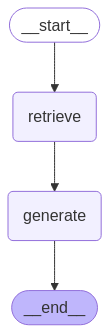

In [10]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [11]:
result = graph.invoke({"question": "How fast are cheetahs?"})


print(f"Result: {result}\n\n")
sources = [doc.metadata["source"] for doc in result["context"]]
print(f"Sources: {sources}\n\n")
print(f"Answer: {result['answer']}")

Result: {'question': 'How fast are cheetahs?', 'context': [Document(metadata={'title': 'Cheetah', 'summary': 'The cheetah (Acinonyx jubatus) is a large cat and the fastest land animal. It has a tawny to creamy white or pale buff fur that is marked with evenly spaced, solid black spots. The head is small and rounded, with a short snout and black tear-like facial streaks. It reaches 67–94 cm (26–37 in) at the shoulder, and the head-and-body length is between 1.1 and 1.5 m (3 ft 7 in and 4 ft 11 in). Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail.\nThe cheetah was first described in the late 18th century. Four subspecies are recognised today that are native to Africa and central Iran. An African subspecies was introduced to India in 2022. It is now distributed mainly in small, fragmented populations in northwester

# Tool-calling

If your LLM of choice implements a tool-calling feature, you can use it to make the model specify which of the provided documents it's referencing when generating its answer. LangChain tool-calling models implement a .with_structured_output method which will force generation adhering to a desired schema (see details here).

## Cited documents

To cite documents using an identifier, we format the identifiers into the prompt, then use .with_structured_output to coerce the LLM to reference these identifiers in its output.

First we define a schema for the output. The .with_structured_output supports multiple formats, including JSON schema and Pydantic. Here we will use Pydantic:


In [12]:
from pydantic import BaseModel, Field


class CitedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""
    answer: str = Field(..., description="The answer to the user question, which is based only on the given sources.")
    citations: List[int] = Field(..., description="The integer IDs of the SPECIFIC sources which justify the answer.")

Let's see what the model output is like when we pass in our functions and a user input:


In [13]:
structured_llm = llm.with_structured_output(CitedAnswer)

example_q = """What is Brian's height?

Source: 1
Information: Suzy is 6'2

Source: 2
Information: Jeremiah is blonde

Source: 3
Information: Brian is 3 inches shorter than Suzy"""

result = structured_llm.invoke(example_q)

result

CitedAnswer(answer="Brian is 5'11.", citations=[1, 3])

Or as a dict:


In [14]:
result.model_dump()

{'answer': "Brian is 5'11.", 'citations': [1, 3]}

Now we structure the source identifiers into the prompt to replicate with our chain. We will make three changes:

1. Update the prompt to include source identifiers;
2. Use the structured_llm (i.e., llm.with_structured_output(CitedAnswer));
3. Return the Pydantic object in the output.


In [15]:
def format_docs_with_id(docs: List[Document]) -> str:
    formatted = [
        f"Source ID: {i}\nArticle Title: {doc.metadata['title']}\nArticle Snippet: {doc.page_content}"
        for i, doc in enumerate(docs)
    ]
    return "\n\n" + "\n\n".join(formatted)


class State(TypedDict):
    question: str
    context: List[Document]
    answer: CitedAnswer


def generate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = prompt.invoke(input={"question": state["question"], "context": formatted_docs})
    structured_llm = llm.with_structured_output(CitedAnswer)
    response = structured_llm.invoke(messages)

    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [16]:
result = graph.invoke(input={"question": "How fast are cheetahs?"})

result["answer"]

CitedAnswer(answer='Cheetahs are capable of running at speeds of 93 to 104 km/h (58 to 65 mph), making them the fastest land animals.', citations=[0, 4])

We can inspect the document at index 0, which the model cited:


In [17]:
print(result["context"][0])

page_content='The cheetah (Acinonyx jubatus) is a large cat and the fastest land animal. It has a tawny to creamy white or pale buff fur that is marked with evenly spaced, solid black spots. The head is small and rounded, with a short snout and black tear-like facial streaks. It reaches 67–94 cm (26–37 in) at the shoulder, and the head-and-body length is between 1.1 and 1.5 m (3 ft 7 in and 4 ft 11 in). Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail.
The cheetah was first described in the late 18th century. Four subspecies are recognised today that are native to Africa and central Iran. An African subspecies was introduced to India in 2022. It is now distributed mainly in small, fragmented populations in northwestern, eastern and southern Africa and central Iran. It lives in a variety of habitats such as savann

## Cite Snippets

To return text spans (perhaps in addition to source identifiers), we can use the same approach. The only change will be to build a more complex output schema, here using Pydantic, that includes a "quote" alongside a source identifier.

Aside: Note that if we break up our documents so that we have many documents with only a sentence or two instead of a few long documents, citing documents becomes roughly equivalent to citing snippets, and may be easier for the model because the model just needs to return an identifier for each snippet instead of the actual text. Probably worth trying both approaches and evaluating.


In [18]:
class Citation(BaseModel):
    source_id: int = Field(..., description="The integer ID of a SPECIFIC source which justifies the answer.")
    quote: str = Field(..., description="The VERBATIM quote from the specified source that justifies the asnwer.")


class QuotedAnswer(BaseModel):
    """Answer the user question based only on the given sources, and cite the sources used."""
    answer: str = Field(..., description="The answer to the user question, which is based only on the given sources.")
    citations: List[Citation] = Field(..., description="Citations from the given sources that justify the answer.")

In [19]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: QuotedAnswer


def generate(state: State):
    formattted_docs = format_docs_with_id(docs=state["context"])
    messages = prompt.invoke({"question": state["question"], "context": formattted_docs})
    structured_llm = llm.with_structured_output(QuotedAnswer)
    response = structured_llm.invoke(input=messages)
    return {"answer": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Here we see that the model has extracted a relevant snippet of text from source 0:


In [20]:
result = graph.invoke({"question": "How fast are cheetahs?"})

result["answer"]

QuotedAnswer(answer='Cheetahs can run at speeds between 93 to 104 km/h (58 to 65 mph).', citations=[Citation(source_id=0, quote='The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail.')])

# Direct prompting

Some models don't support function-calling. We can achieve similar results with direct prompting. Let's try instructing a model to generate structured XML for its output:


In [24]:
%pip install defusedxml

Using cached defusedxml-0.7.1-py2.py3-none-any.whl (25 kB)
Note: you may need to restart the kernel to use updated packages.


In [21]:
xml_system = """You're a helpful AI assistant. Given a user question and some Wikipedia article snippets, \
answer the user question and provide citations. If none of the articles answer the question, just say you don't know.

Remember, you must return both an answer and citations. A citation consists of a VERBATIM quote that \
justifies the answer and the ID of the quote article. Return a citation for every quote across all articles \
that justify the answer. Use the following format for your final output:

<cited_answer>
    <answer></answer>
    <citations>
        <citation><source_id></source_id><quote></quote></citation>
        <citation><source_id></source_id><quote></quote></citation>
        ...
    </citations>
</cited_answer>

Here are the Wikipedia articles:{context}"""
xml_prompt = ChatPromptTemplate.from_messages(
    [("system", xml_system), ("human", "{question}")]
)

We now make similar small updates to our chain:

1. We update the formatting function to wrap the retrieved context in XML tags;
2. We do not use .with_structured_output (e.g., because it does not exist for a model);
3. We use XMLOutputParser to parse the answer into a dict.


In [22]:
from langchain_core.output_parsers import XMLOutputParser


def format_docs_xml(docs: List[Document]) -> str:
    formatted = []
    for i, doc in enumerate(docs):
        doc_str = f"""\
    <source_id=\"{i}">
        <title>{doc.metadata["title"]}</title>
        <article_snippet>{doc.page_content}</article_snippet>
    </source>"""
        formatted.append(doc_str)
    return "\n\n<sources>" + "\n".join(formatted) + "</sources>"


class State(TypedDict):
    question: str
    context: List[Document]
    answer: dict


def generate(state: State):
    formatted_docs = format_docs_xml(docs=state["context"])
    messages = xml_prompt.invoke(input={"question": state["question"],
                                        "context": formatted_docs})
    response = llm.invoke(messages)
    parsed_response = XMLOutputParser().invoke(response)
    return {"answer": parsed_response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

Note that citations are again structured into the answer:


In [25]:
result = graph.invoke({"question": "How fast are cheetahs?"})

result["answer"]

{'cited_answer': [{'answer': 'The cheetah is capable of running at speeds of 93 to 104 km/h (58 to 65 mph).'},
  {'citations': [{'citation': [{'source_id': '0'},
      {'quote': 'it is capable of running at 93 to 104 km/h (58 to 65 mph)'}]}]}]}

# Retrieval post-processing

Another approach is to post-process our retrived documents to compress the content, so that the source content is already minimal enough that we don't need the model to cite specific sources or spans. For example, we could break up each document into a sentence or two, embed those and keep only the most relevant ones. LangChain has some built-in components for this. Here we'll use a RecursiveCharacterTextSplitter, which creates chunks of a specified size by splitting on separator substrings, and an EmbeddingsFilter, which keeps only the texts with the most relevant embeddings.

This approach effectivel updates our retrieve step to compress the documents. Let's first select an embedding model


In [26]:
import getpass
import os

if not os.environ.get("OPENAI_API_KEY"):
    os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

We can now rewrite the retrieve step:


In [27]:
from langchain.retrievers.document_compressors import EmbeddingsFilter
from langchain_text_splitters import RecursiveCharacterTextSplitter

splitter = RecursiveCharacterTextSplitter(
    chunk_size=400,
    chunk_overlap=0,
    separators=["\n\n", "\n", ".", " "],
    keep_separator=False
)
compressor = EmbeddingsFilter(embeddings=embeddings, k=10)


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str


def retrieve(state: State):
    retrieved_docs = retriever.invoke(input=state["question"])
    split_docs = splitter.split_documents(retrieved_docs)
    # Filter documents based on similarity of their embeddings to the query.
    stateful_docs = compressor.compress_documents(documents=split_docs, query=state["question"])
    return {"context": stateful_docs}

Let's test this out:


In [28]:
retrieval_result = retrieve(state={"question": "How fast are cheetahs?"})

for doc in retrieval_result["context"]:
    print(f"{doc.page_content}\n\n")

Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail


The cheetah (Acinonyx jubatus) is a large cat and the fastest land animal. It has a tawny to creamy white or pale buff fur that is marked with evenly spaced, solid black spots. The head is small and rounded, with a short snout and black tear-like facial streaks. It reaches 67–94 cm (26–37 in) at the shoulder, and the head-and-body length is between 1.1 and 1.5 m (3 ft 7 in and 4 ft 11 in)


2 mph), or 171 body lengths per second. The cheetah, the fastest land mammal, scores at only 16 body lengths per second


It feeds on small- to medium-sized prey, mostly weighing under 40 kg (88 lb), and prefers medium-sized ungulates such as impala, springbok and Thomson's gazelles. The cheetah typically stalks its prey within 60–100 m (200–330 ft) before charging towards it,

Next, we assemble it into our chain as before:


In [29]:
# This step is unchanged from our original RAG implementation
def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke(input={"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

In [30]:
result = graph.invoke({"question": "How fast are cheetahs?"})

print(result["answer"])

Cheetahs are capable of running at speeds between 93 to 104 km/h (58 to 65 mph), making them the fastest land animals.


Note that the document content is now compressed, although the document objects retain the original content in a "summary" key in their metadata. These summaries are not passed to the model; only the condensed content is.


In [31]:
result["context"][0].page_content  # passed to model

'Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail'

In [32]:
result["context"][0].metadata["summary"]  # original document

'The cheetah (Acinonyx jubatus) is a large cat and the fastest land animal. It has a tawny to creamy white or pale buff fur that is marked with evenly spaced, solid black spots. The head is small and rounded, with a short snout and black tear-like facial streaks. It reaches 67–94 cm (26–37 in) at the shoulder, and the head-and-body length is between 1.1 and 1.5 m (3 ft 7 in and 4 ft 11 in). Adults weigh between 21 and 65 kg (46 and 143 lb). The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed, including a light build, long thin legs and a long tail.\nThe cheetah was first described in the late 18th century. Four subspecies are recognised today that are native to Africa and central Iran. An African subspecies was introduced to India in 2022. It is now distributed mainly in small, fragmented populations in northwestern, eastern and southern Africa and central Iran. It lives in a variety of habitats such as savannahs in the S

# Generation post-processing

Another approach is to post-process our model generation. In this example we'll first generate just an answer, and then we'll ask the model to annotate it's own answer with citations. The downside of this approach is of course that it is slower and more expensive, because two model calls need to be made.

Let's apply this to our initial chain. If desired, we can implement this via a third step in our application.


In [33]:
class Citation(BaseModel):
    source_id: int = Field(
        ...,
        description="The integer ID of a SPECIFIC source which justifies the answer.",
    )
    quote: str = Field(
        ...,
        description="The VERBATIM quote from the specified source that justifies the answer.",
    )


class AnnotatedAnswer(BaseModel):
    """Annotate the answer to the user question with quote citations that justify the answer."""

    citations: List[Citation] = Field(
        ..., description="Citations from the given sources that justify the answer."
    )


structured_llm = llm.with_structured_output(AnnotatedAnswer)

In [34]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str
    annotations: AnnotatedAnswer


def retrieve(state: State):
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


def annotate(state: State):
    formatted_docs = format_docs_with_id(state["context"])
    messages = [
        ("system", system_prompt.format(context=formatted_docs)),
        ("human", state["question"]),
        ("ai", state["answer"]),
        ("human", "Annotate your answer with citations."),
    ]
    response = structured_llm.invoke(messages)
    return {"annotations": response}


graph_builder = StateGraph(State).add_sequence([retrieve, generate, annotate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

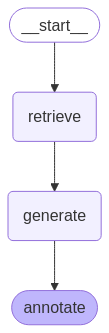

In [35]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
result = graph.invoke({"question": "How fast are cheetahs?"})

print(result["answer"])

Cheetahs are capable of running at speeds of 93 to 104 km/h (58 to 65 mph).


In [37]:
result["annotations"]

AnnotatedAnswer(citations=[Citation(source_id=0, quote='The cheetah is capable of running at 93 to 104 km/h (58 to 65 mph); it has evolved specialized adaptations for speed.')])